In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import librosa as lb
import scipy.io.wavfile as wave
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
import scipy.special as sp
import librosa.display as lbd

# Enhancement to Noisy Dataset

In [5]:
def mmseProcessing(x, frame_length):

    hop_length = frame_length // 2
    len2 = frame_length - hop_length 

    # setting default parameters
    aa = 0.98
    eta = 0.15
    snr_threshold = 3
    mu = 0.98
    c = np.sqrt(np.pi) / 2
    qk = 0.3
    qkr = (1 - qk) / qk
    ksi_min = 10 ** (-30 / 10)

    hamming_window = np.hamming(frame_length)
    hamming_windowGain = len2 / sum(hamming_window)

    nFFT = 2 * 2 ** np.log2(frame_length).astype(int)
    j = 1
    noise_mean = np.zeros(nFFT)
    for k in range(1, 6):
        noise_mean = noise_mean + abs(np.fft.fft(hamming_window * x[j : j + frame_length] , nFFT))
        j = j + frame_length
    noise_est = noise_mean / 5
    noise_est2 = noise_est ** 2

    # initialize variables
    k = 1
    x_old = np.zeros(len2)
    Nframes = len(x) // len2 - 1
    y = np.zeros(Nframes * len2)

    for n in range(0, Nframes):

        windowed_frame = hamming_window * x[k - 1 : k + frame_length - 1]

        # Take fourier transform of frame
        wf_fft = np.fft.fft(windowed_frame , nFFT)
        sig = abs(wf_fft)
        sig_sq = sig ** 2

        theta = np.angle(wf_fft)  

        snr_sig = 10 * np.log10(np.linalg.norm(sig, 2) ** 2 / np.linalg.norm(noise_est, 2) ** 2)

        gammak = np.minimum(sig_sq / noise_est2 , 40) 
        
        if n == 0:
            ksi = aa + (1 - aa) * np.maximum(gammak - 1 , 0)
        else:
            ksi = aa * Xk_prev / noise_est2 + (1 - aa) * np.maximum(gammak - 1 , 0)

            ksi = np.maximum(ksi_min , ksi)  

        if snr_sig < snr_threshold: 
            noise_est2 = mu * noise_est2 + (1 - mu) * sig_sq 
            noise_est = np.sqrt(noise_est2)

        vk = gammak * ksi / (1 + ksi)
        j_0 = sp.iv(0 , vk/2)
        j_1 = sp.iv(1 , vk/2)    
        C = np.exp(-0.5 * vk)
        A = ((c * (vk ** 0.5)) * C) / gammak      
        B = (1 + vk) * j_0 + vk * j_1             
        hw = A * B                              
    
        mmse_speech = hw * sig

        Xk_prev = mmse_speech ** 2  

        x_spec_new = mmse_speech * np.exp(1j * theta)
        new_x = np.fft.ifft(x_spec_new , nFFT).real

        y[k - 1 : k + len2 - 1] = x_old + new_x[0:hop_length]
        x_old = new_x[hop_length:frame_length]

        k = k + len2
        
    return y * hamming_windowGain

In [6]:
path = r"F:\SSP\Project\enhanced_factory_dataset"
files = glob.glob(path+"\*\*\*\*.wav")
for file in files:
    data,fs = lb.load(file)
    enhancedSignal = mmseProcessing(data, 1024)
    wave.write(file,fs,enhancedSignal)    

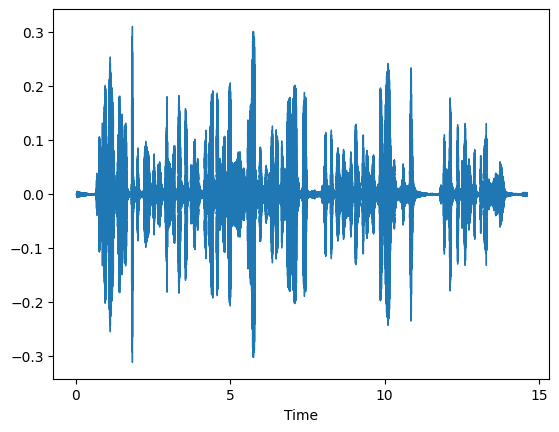

In [7]:
lbd.waveshow(enhancedSignal, sr=fs)

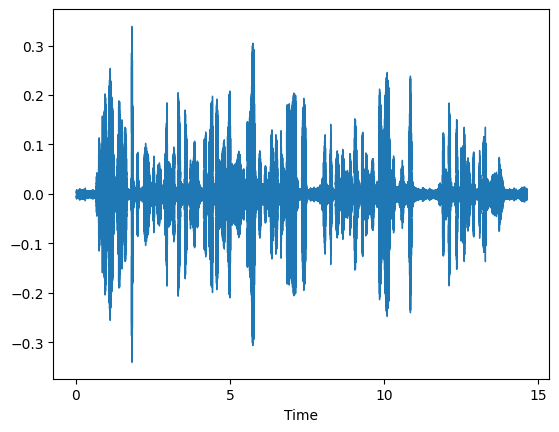

In [8]:
lbd.waveshow(data, sr=fs)